In [98]:
from community import community_louvain
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import seaborn as sns


%matplotlib inline
pd.set_option('display.max_colwidth', 120)

In [3]:
!ls data-project1/

follower_network.csv output_tweet.csv     top_tweet_agents.csv


## Data Acquisition

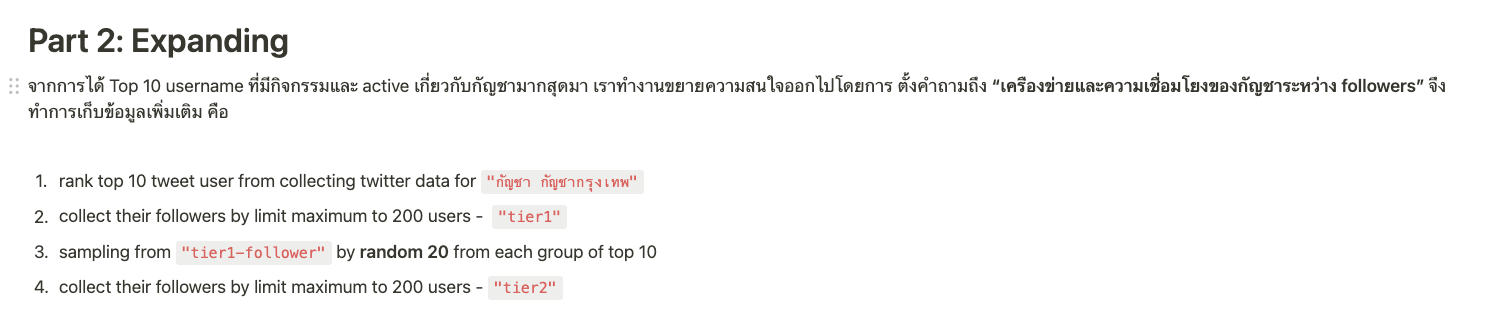

user/account = node

follower => in-degree

following => out-degre

In [4]:
fol_df=pd.read_csv('data-project1/follower_network.csv')

## Exploratory Data Analysis

In [58]:
fol_df.dtypes

source_id         int64
source_name      object
follower_name    object
follower_id       int64
location         object
description      object
dtype: object

In [21]:
fol_df.columns

Index(['source_id', 'source_name', 'follower_name', 'follower_id', 'location',
       'description'],
      dtype='object')

In [20]:
fol_df.head()

source_id source_name    follower_name          follower_id  \
0  1554768110963478528     42xWeeD  C9xMggNjYe4e6GI  1396605027532238848   
1  1554768110963478528     42xWeeD     Benz23625920  1351745154344919042   
2  1554768110963478528     42xWeeD          Doy1237  1417122611482427395   
3  1554768110963478528     42xWeeD   HighBerHerb420  1568813694355918848   
4  1554768110963478528     42xWeeD      phlab_thxng  1571090237526536193   

            location  \
0                NaN   
1                NaN   
2                NaN   
3  Bangkok, Thailand   
4                NaN   

                                                       description  
0                                                              NaN  
1                                                              NaN  
2                                                              NaN  
3  Cannabis shop \nExotic, Top-shelf, mid-grade,low-grade\nส่ง+50฿  
4                                                              NaN

In [49]:
fol_df[['source_id','follower_id']].drop_duplicates().shape

(9581, 2)

In [51]:
fol_df=fol_df.drop_duplicates()

In [101]:
source_df=fol_df['source_id'].drop_duplicates()
follow_df=fol_df['follower_id'].drop_duplicates()

In [104]:
source_df.shape, follow_df.shape

((172,), (7559,))

In [390]:
fol_df['source_id'].value_counts().reset_index().rename(columns={'index':'follower_name', 'source_id':'follower_count'})
# fol_df['follower_id'].value_counts().reset_index()
# fol_df.groupby('source_id').count().sort_values('follower_name', ascending=False).reset_index()[['source_id','follower_name']].rename(columns={'follower_name':'follower_count'})

follower_name  follower_count
0    1536602206803152896             200
1    1559048834852220928             200
2    1117415753613897729             200
3    1348282458807148545             200
4    1500538521253466113             200
..                   ...             ...
167  1565318500239175680               1
168  1444804486011047942               1
169  1454726977076690947               1
170  1369354671140331523               1
171  1409165436059488258               1

[172 rows x 2 columns]

In [392]:
fol_df[fol_df['source_id']==1536602206803152896].head()

source_id  source_name    follower_name          follower_id  \
7258  1536602206803152896  Boy72323239         zonozeno  1213716591902199809   
7259  1536602206803152896  Boy72323239   Tzivya48456758  1567058064498384896   
7260  1536602206803152896  Boy72323239   khxlln48472732  1568873755442806785   
7261  1536602206803152896  Boy72323239      Top83619507  1563050512651808768   
7262  1536602206803152896  Boy72323239  bLhIw9GdUf4IJST  1551938454682218496   

                 location               description  
7258  อุดรธานี, ประเทศไทย  รุก ภายนอก เอ้าท์ดอ ป๊อป  
7259                  NaN                       NaN  
7260                  NaN                       NaN  
7261                  NaN                       NaN  
7262                  NaN                       NaN

In [394]:
fol_df['follower_id'].value_counts().reset_index().rename(columns={'index':'follower_id', 'follower_id': 'following_count'})
# fol_df.groupby(['follower_id']).count().sort_values('source_id', ascending=False).reset_index()[['follower_id','source_id']].rename(columns={'source_id':'following_count'})

follower_id  following_count
0     1559048834852220928               82
1     1568867553661046785               39
2     1495303418113855489               38
3     1551815910834728961               31
4     1533398325960929280               29
...                   ...              ...
7554  1560156171885051905                1
7555  1560163876024774656                1
7556  1202795351687610368                1
7557  1560387870816632833                1
7558  1505770881435709440                1

[7559 rows x 2 columns]

In [395]:
fol_df[fol_df['follower_id']==1559048834852220928].head()

source_id      source_name  follower_name  \
663   1183085379202633728  GUEST6607526277  greenyard4420   
850   1551239508720422918     smokequeen89  greenyard4420   
1104  1559885381654327297        420weedog  greenyard4420   
1338  1226150426241687558          izeizex  greenyard4420   
1573  1567752491022024706        1maillion  greenyard4420   

              follower_id      location  \
663   1559048834852220928  Samutprakarn   
850   1559048834852220928  Samutprakarn   
1104  1559048834852220928  Samutprakarn   
1338  1559048834852220928  Samutprakarn   
1573  1559048834852220928  Samutprakarn   

                                                                                                                  description  
663   กัญชาสายพันธุ์นอกMid Grade Top Premiun รับประกันความเมา👾🤖👽 ส่งทั่วไทย🇹🇭 ส่งด่วนสมุทรปราการ🏍 เครดิตแน่น ทวิตเก่าโดนแบ...  
850   กัญชาสายพันธุ์นอกMid Grade Top Premiun รับประกันความเมา👾🤖👽 ส่งทั่วไทย🇹🇭 ส่งด่วนสมุทรปราการ🏍 เครดิตแน่น ทวิตเก่าโดนแบ...  
1104  กัญชาสายพันธุ์นอกMid Grade Top Premiun รับประกันความเมา👾🤖👽 ส่งทั่วไทย🇹🇭 ส่งด่วนสมุทรปราการ🏍 เครดิตแน่น ทวิตเก่าโดนแบ...  
1338  กัญชาสายพันธุ์นอกMid Grade Top Premiun รับประกันความเมา👾🤖👽 ส่งทั่วไทย🇹🇭 ส่งด่วนสมุทรปราการ🏍 เครดิตแน่น ทวิตเก่าโดนแบ...  
1573  กัญชาสายพันธุ์นอกMid Grade Top Premiun รับประกันความเมา👾🤖👽 ส่งทั่วไทย🇹🇭 ส่งด่วนสมุทรปราการ🏍 เครดิตแน่น ทวิตเก่าโดนแบ...

In [397]:
# follower_count_df=fol_df.groupby('source_id').count().sort_values('follower_name', ascending=False).reset_index()[['source_id','follower_name']].rename(columns={'source_id':'account_id','follower_name':'follower_count'})
# following_count_df=fol_df.groupby(['follower_id']).count().sort_values('source_id', ascending=False).reset_index()[['follower_id','source_id']].rename(columns={'follower_id':'account_id','source_id':'following_count'})

In [398]:
follower_count_df=fol_df['source_id'].value_counts().reset_index().rename(columns={'index':'account_id', 'source_id':'follower_count'})
following_count_df=fol_df['follower_id'].value_counts().reset_index().rename(columns={'index':'account_id', 'follower_id': 'following_count'})

In [65]:
# visual behaviour of user

In [401]:
follower_count_df.shape, following_count_df.shape

((172, 2), (7559, 2))

In [402]:
df3=pd.merge(following_count_df, follower_count_df, how="outer", on=["account_id"]).fillna(0)

In [403]:
# คนขายแน่ๆ behaviour จัดและชัด 
df3[(df3['follower_count']==df3['follower_count'].max()) & (df3['following_count']==df3['following_count'].min())].reset_index(drop=True)

account_id  following_count  follower_count
0             63018215              0.0           200.0
1  1183085379202633728              0.0           200.0
2  1397569068652064770              0.0           200.0
3  1551239508720422918              0.0           200.0

In [405]:
fol_df[fol_df['source_id']==63018215].head()

source_id source_name  follower_name          follower_id  \
65   63018215     BooK_Ku  Sweeddyshopv2  1567111030568001536   
66   63018215     BooK_Ku     littlepigw           3181919426   
67   63018215     BooK_Ku    WangmanowOg  1566205717433835520   
68   63018215     BooK_Ku   Anne82673743  1564419363775848448   
69   63018215     BooK_Ku      S_K_Y_S_K  1142008929477517313   

                location  \
65                   NaN   
66                   NaN   
67  Bangkok Noi, Bangkok   
68                   NaN   
69                   NaN   

                                                                                                                description  
65  💎 Premium Product High Quality 💎\n\nline 📲 https://t.co/Q4Sy87ZwGC\n\n#Exotic #TopShelf 🏆\n\n🛫 จัดส่งทั่วโลก 🛫\n\nกท...  
66                                                                                                                      NaN  
67                        🥦ดอกไม้ ราคาปลีก-ส่ง❗❗\n\n👉 Top shelf, 👉 Exotic 🇹🇭 Thai Fram \n\nมีเครดิตเช็คได้  DM ✉️ มาเลยครับ  
68                                                                                                                      NaN  
69                                                                                                                   ผู้ชาย

In [423]:
df3['abs_diff']=abs(df3['following_count']-df3['follower_count'])

In [430]:
df3.sort_values('abs_diff', ascending=False)[:10]

account_id  following_count  follower_count  abs_diff
7562  1551239508720422918              0.0           200.0     200.0
7561  1397569068652064770              0.0           200.0     200.0
7560  1183085379202633728              0.0           200.0     200.0
7559             63018215              0.0           200.0     200.0
5171  1500538521253466113              1.0           200.0     199.0
5647  1536602206803152896              1.0           200.0     199.0
5000  1444039461210259456              1.0           200.0     199.0
5188  1499480075879993344              1.0           200.0     199.0
3840  1536099003556696065              1.0           200.0     199.0
5487            635106004              1.0           200.0     199.0

### Location analysis

In [74]:
# 31% that tell(open) thier location
(fol_df[~fol_df['location'].isnull()].shape[0])*100/fol_df.shape[0]

31.009289218244444

In [90]:
loc_df=fol_df[~fol_df['location'].isnull()].drop_duplicates()

In [501]:
loc_df[['location']].drop_duplicates()

location
3               Bangkok, Thailand
6                       ประเทศไทย
10                         Pathum
20     Amphoe Mueang Nakhon Sawan
22                             LA
...                           ...
10147       อ.นางรอง, จ.บุรีรัมย์
10186               Jurupa Valley
10189   اسلام آباد G9/2, Pakistan
10190                       🇵🇰~🇰🇼
10191                  Everywhere

[1124 rows x 1 columns]

In [97]:
# visual location

In [510]:
loc_df['location'].tolist()

['Bangkok, Thailand',
 'ประเทศไทย',
 'Pathum',
 'Amphoe Mueang Nakhon Sawan',
 'LA',
 'Bangkok, Thailand',
 'นนทบุรี, ประเทศไทย',
 'Rayong, Thailand',
 'Bangkok, Thailand',
 'กรุงเทพมหานคร, ประเทศไทย',
 'Thailand',
 'อ.หนองไผ่, จ.เพชรบูรณ์',
 'สมุทรปราการ',
 'นนทบุรี',
 'อ.เมืองนครราชสีมา, จ.นครราชสีม',
 'จ.สระบุรี, ประเทศไทย',
 'Bangkok Noi, Bangkok',
 'Nakhon Si Thammarat, Thailand',
 'ขุขันธ์',
 'กทม',
 'อ.เมืองภูเก็ต, จ.ภูเก็ต',
 'บนหัวใครสักคนที่รู้สึกหนักๆ',
 'สมุทรปราการ, ประเทศไทย',
 'Bangkok, Thailand',
 'ร้านกาแฟในตรอกไดแอกอน',
 'Thailand',
 'นครราชสีมา, ประเทศไทย',
 'ศรีสะเกษ',
 'กรุงเทพมหานคร, ประเทศไทย',
 'Rasi Salai, Thailand',
 'Bangkok, Thailand',
 'Bang Khen, Bangkok',
 'Chon Buri Province, Thailand',
 'อ.ศรีราชา, จ.ชลบุรี',
 'กาญจนบุรี, ประเทศไทย เขาชนไก่',
 'ทุ่งครุ, กรุงเทพมหานคร',
 'สระแก้ว',
 'Bangkok, Thailand',
 'อ.เมืองสมุทรสาคร, จ.สมุทรสาคร',
 'Chiang Mai, Thailand',
 'Yannawa, Bangkok',
 'อ.โชคชัย, จ.นครราชสีมา',
 'Si Sa Ket, Thailand',
 'Phone +66 169 696 77

### Description analysis

In [94]:
# 56% that tell(add) thier description
(fol_df[~fol_df['description'].isnull()].shape[0])*100/fol_df.shape[0]

55.850120029224506

In [95]:
desc_df=fol_df[~fol_df['description'].isnull()].drop_duplicates()

In [149]:
desc_df.shape

(5351, 6)

In [89]:
# visual desc_df

In [512]:
# desc_df

### Network EDA

In [17]:
G=nx.from_pandas_edgelist(fol_df, 'source_name', 'follower_name') 

In [18]:
G.number_of_nodes()

7566

In [19]:
G.number_of_edges()

9554

In [108]:
fol_df['source_id'].count()

9581

In [384]:
fol_df.head()

source_id source_name    follower_name          follower_id  \
0  1554768110963478528     42xWeeD  C9xMggNjYe4e6GI  1396605027532238848   
1  1554768110963478528     42xWeeD     Benz23625920  1351745154344919042   
2  1554768110963478528     42xWeeD          Doy1237  1417122611482427395   
3  1554768110963478528     42xWeeD   HighBerHerb420  1568813694355918848   
4  1554768110963478528     42xWeeD      phlab_thxng  1571090237526536193   

            location  \
0                NaN   
1                NaN   
2                NaN   
3  Bangkok, Thailand   
4                NaN   

                                                       description  
0                                                              NaN  
1                                                              NaN  
2                                                              NaN  
3  Cannabis shop \nExotic, Top-shelf, mid-grade,low-grade\nส่ง+50฿  
4                                                              NaN

In [380]:
def create_network (temp_df , node_name):
    # create graph from edges
    temp_df=temp_df[temp_df["source_name"] == node_name][["source_name","follower_name"]]

    G=nx.from_pandas_edgelist(temp_df,"source_name", "follower_name")
    hub_ego = nx.ego_graph(G, node_name)
    pos = nx.spring_layout(hub_ego)  
    nx.draw(hub_ego, 
            pos, 
            node_color="b", 
            node_size=50,
            with_labels=True, 
            font_size=7,
            alpha=.7)
    options = {"node_size": 300, "node_color": "r"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[node_name], **options)
    plt.show()

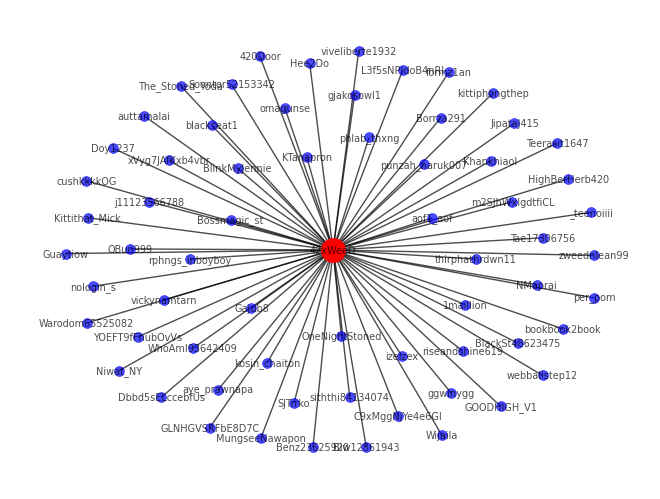

In [381]:
create_network(fol_df, '42xWeeD')

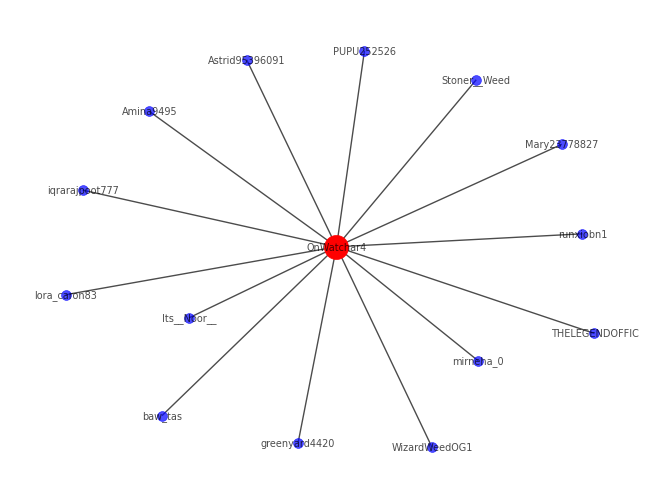

In [383]:
create_network(fol_df, 'OnWatchar4')

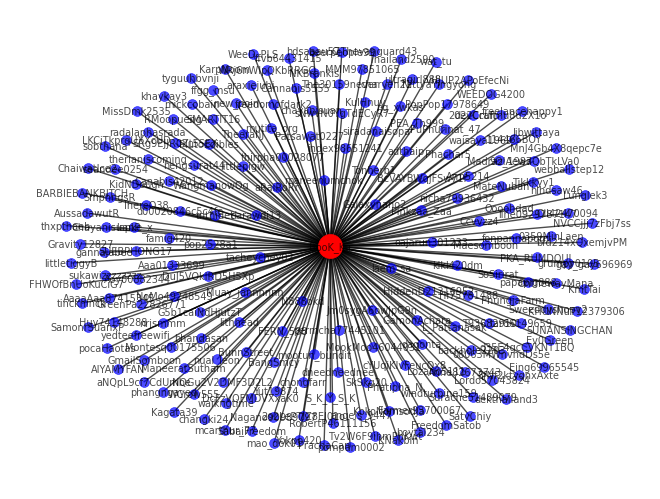

In [386]:
create_network(fol_df, 'BooK_Ku')

## Segment Users

In [139]:
# get number of follows for each follower 
source_df = pd.DataFrame(fol_df['source_id'].value_counts())
# create new dataframe with follower id and number of follows of that follower 
source_df = source_df.reset_index().set_axis(['source', 'follower_count'], axis=1, inplace=False)

In [220]:
def make_segment (value): 
    if value >= 200:
        return "200+"
    elif 200 > value >= 50 :
        return '50+'
    elif 50 > value >= 20 :
        return '20+'
    else :
        return '<10'

In [221]:
source_df['segment'] = source_df['follower_count'].apply(make_segment)

In [222]:
source_df

source  follower_count segment
0    1536602206803152896             200    200+
1    1559048834852220928             200    200+
2    1117415753613897729             200    200+
3    1348282458807148545             200    200+
4    1500538521253466113             200    200+
..                   ...             ...     ...
167  1565318500239175680               1     <10
168  1444804486011047942               1     <10
169  1454726977076690947               1     <10
170  1369354671140331523               1     <10
171  1409165436059488258               1     <10

[172 rows x 3 columns]

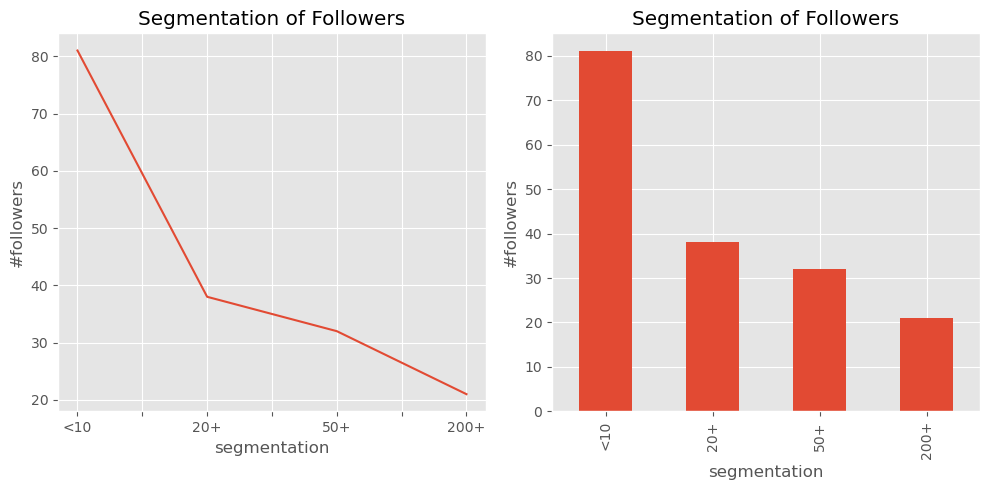

In [223]:
_, axes = plt.subplots(1,2, figsize=(10,5))

source_df['segment'].value_counts().plot(ax = axes[0]) ;
source_df['segment'].sort_index().value_counts().plot(kind = 'bar', ax = axes[1]) ; 

axes[0].set(xlabel="segmentation", ylabel="#followers") ;
axes[1].set(xlabel="segmentation", ylabel="#followers") ;

axes[0].set_title('Segmentation of Followers') ; 
axes[1].set_title('Segmentation of Followers');

axes[0].ticklabel_format(axis="y", style='plain')
axes[1].ticklabel_format(axis="y", style='plain')

plt.tight_layout()

### Similarity 

### Centrality

In [269]:
degreeness = nx.degree_centrality(G)
deg_df=sorted(degreeness.items(), key=lambda x:x[1], reverse=True)

In [277]:
deg_df=pd.DataFrame(deg_df)[:50]

In [282]:
# fig = plt.figure(figsize =(10, 5))
# plt.bar(deg_df[0], deg_df[1], width = 0.5)
# plt.show()

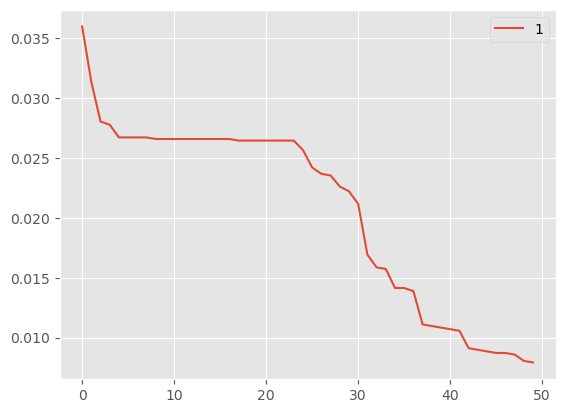

In [284]:
pd.DataFrame(deg_df).sort_index().plot(kind = 'line')
plt.show()

In [285]:
betweenness = nx.betweenness_centrality(G)
bet_df=sorted(betweenness.items(), key=lambda x:x[1], reverse=True)

In [286]:
bet_df=pd.DataFrame(bet_df)[:50]

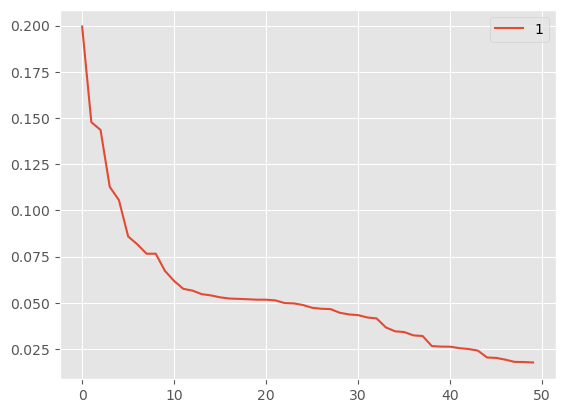

In [287]:
pd.DataFrame(bet_df).sort_index().plot(kind = 'line')
plt.show()

In [235]:
# fol_df[fol_df['source_name']=='Stoner__Weed'].shape
# fol_df[fol_df['follower_name']=='Stoner__Weed'].shape

(200, 6)

## Community Detection

In [433]:
G = nx.from_pandas_edgelist(fol_df, 'source_id', 'follower_id')
pos = nx.spring_layout(G) 

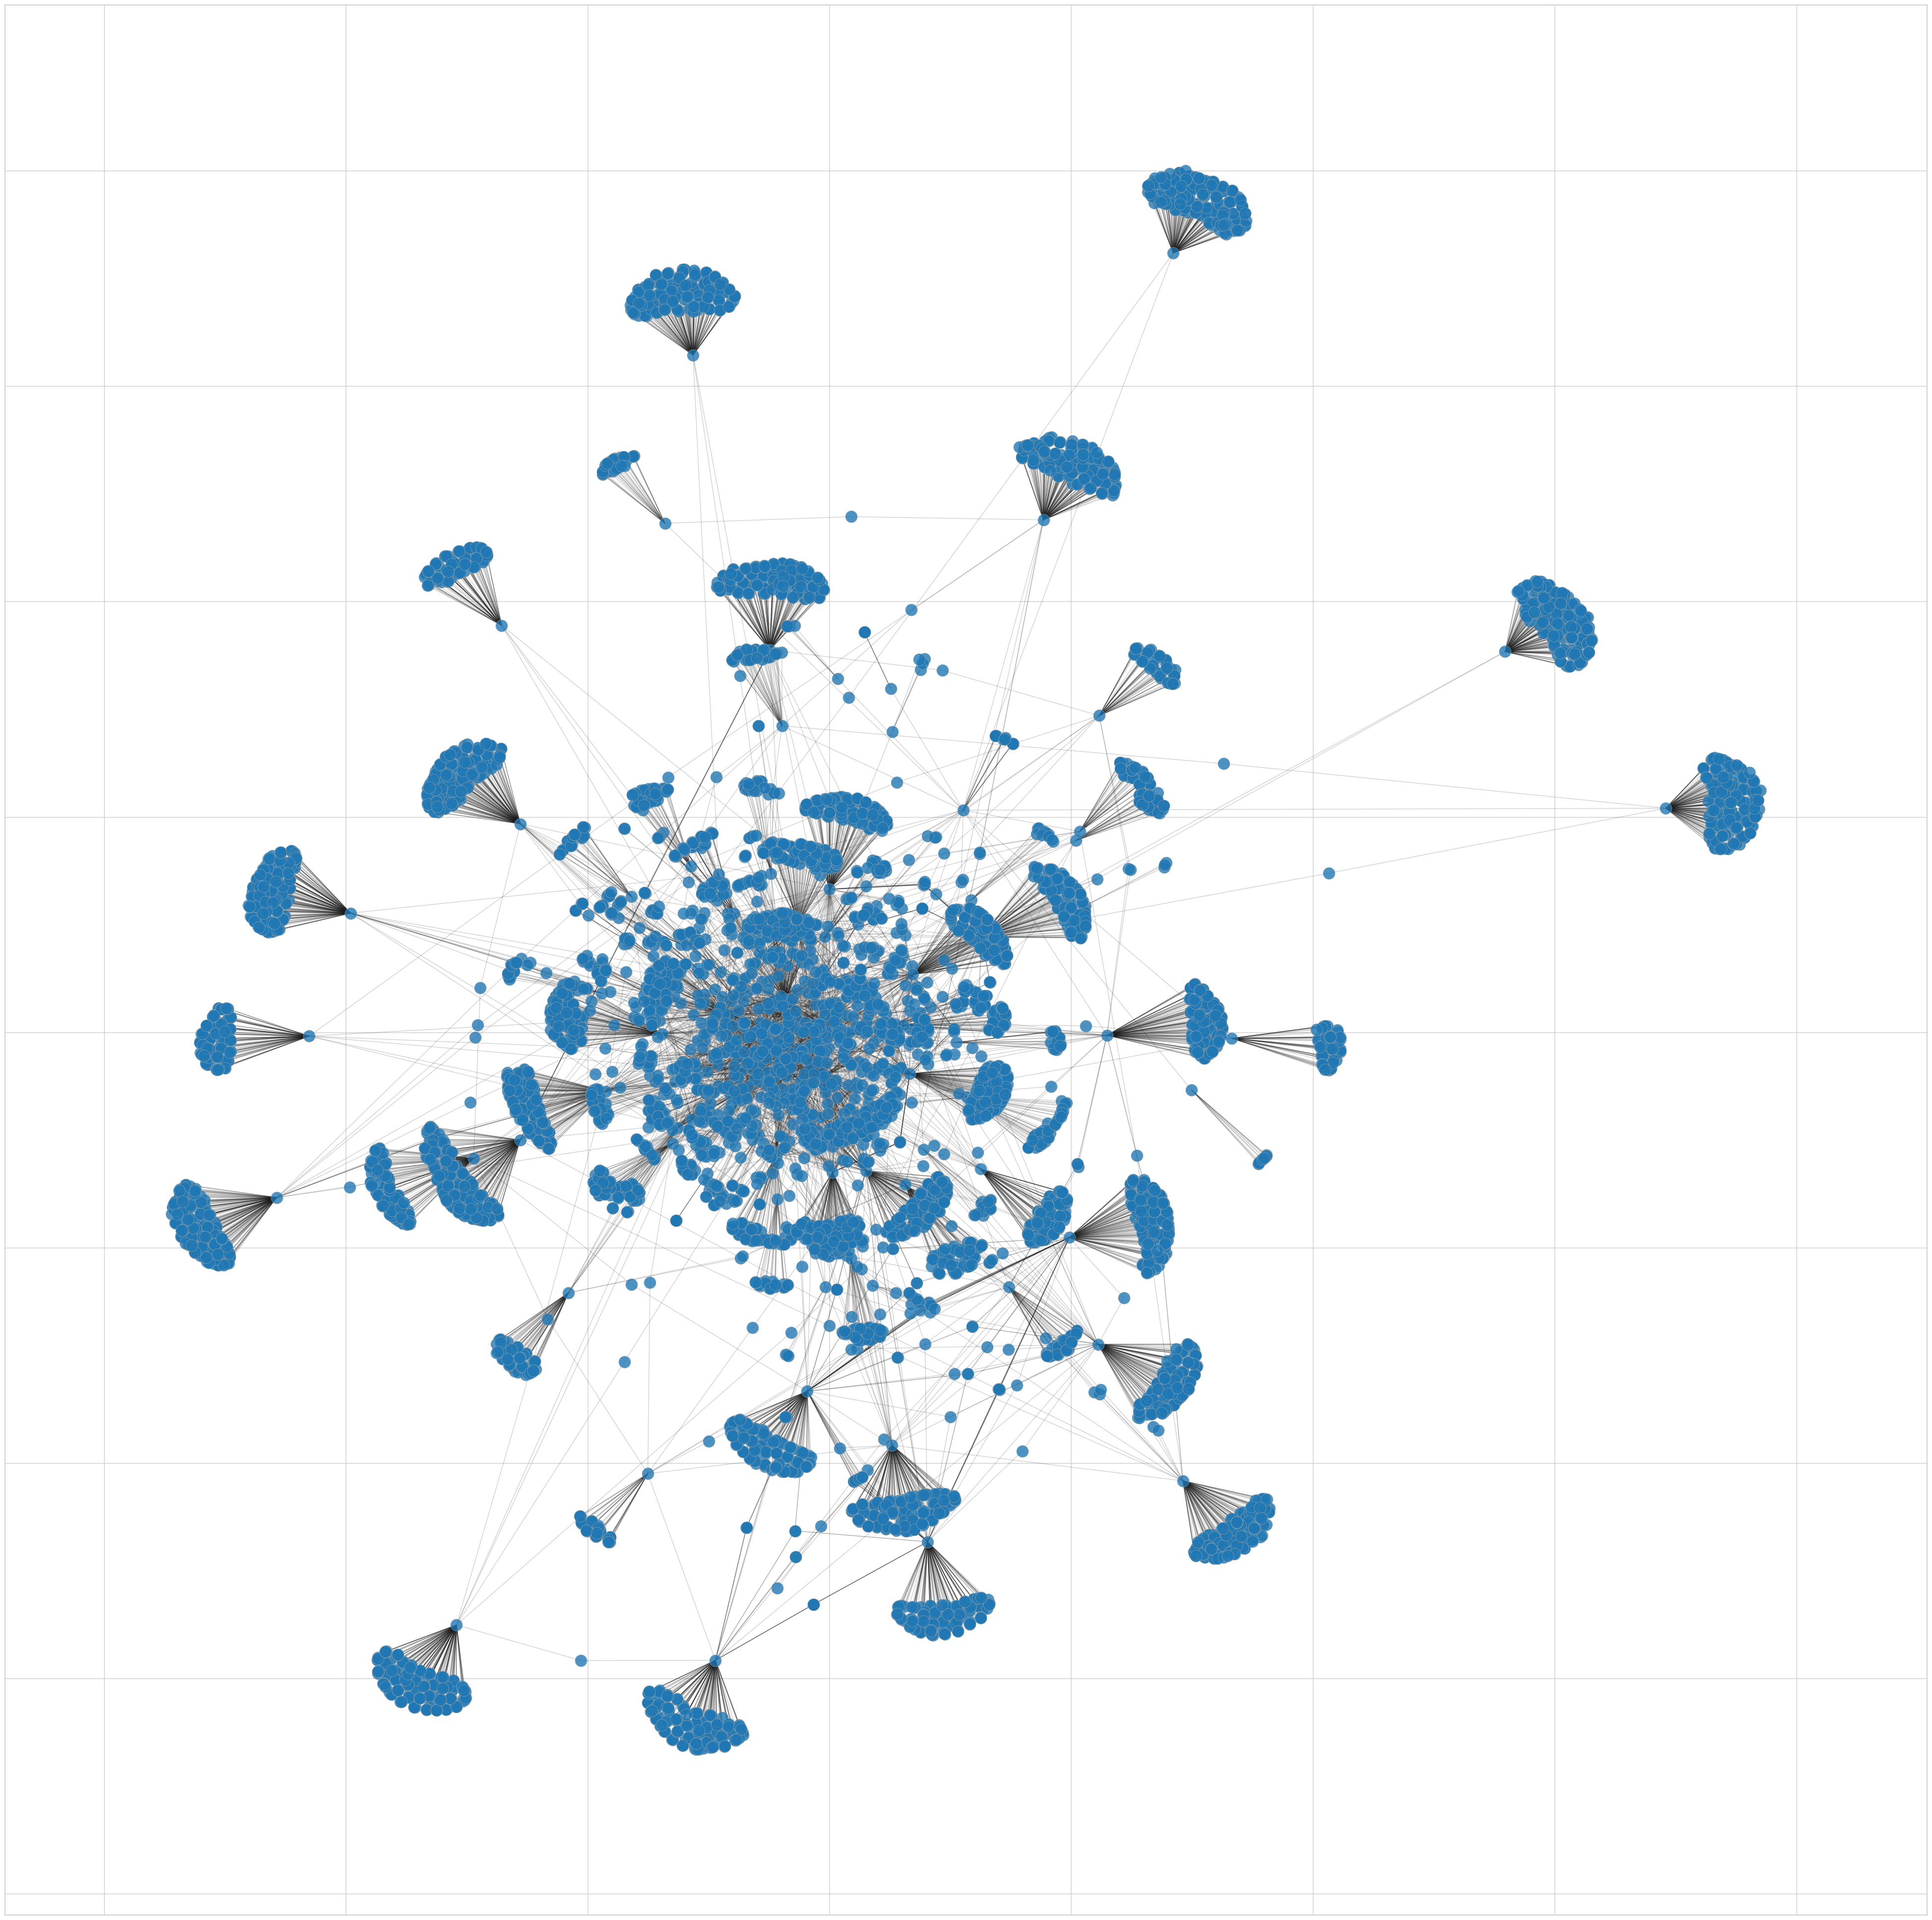

In [434]:
f, ax = plt.subplots(figsize=(50, 50))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos, alpha=0.8)

nodes.set_edgecolor('#AAAAAA')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

In [437]:
position = nx.spring_layout(G)
partition = community_louvain.best_partition(G)
values = [partition.get(node) for node in G.nodes()]

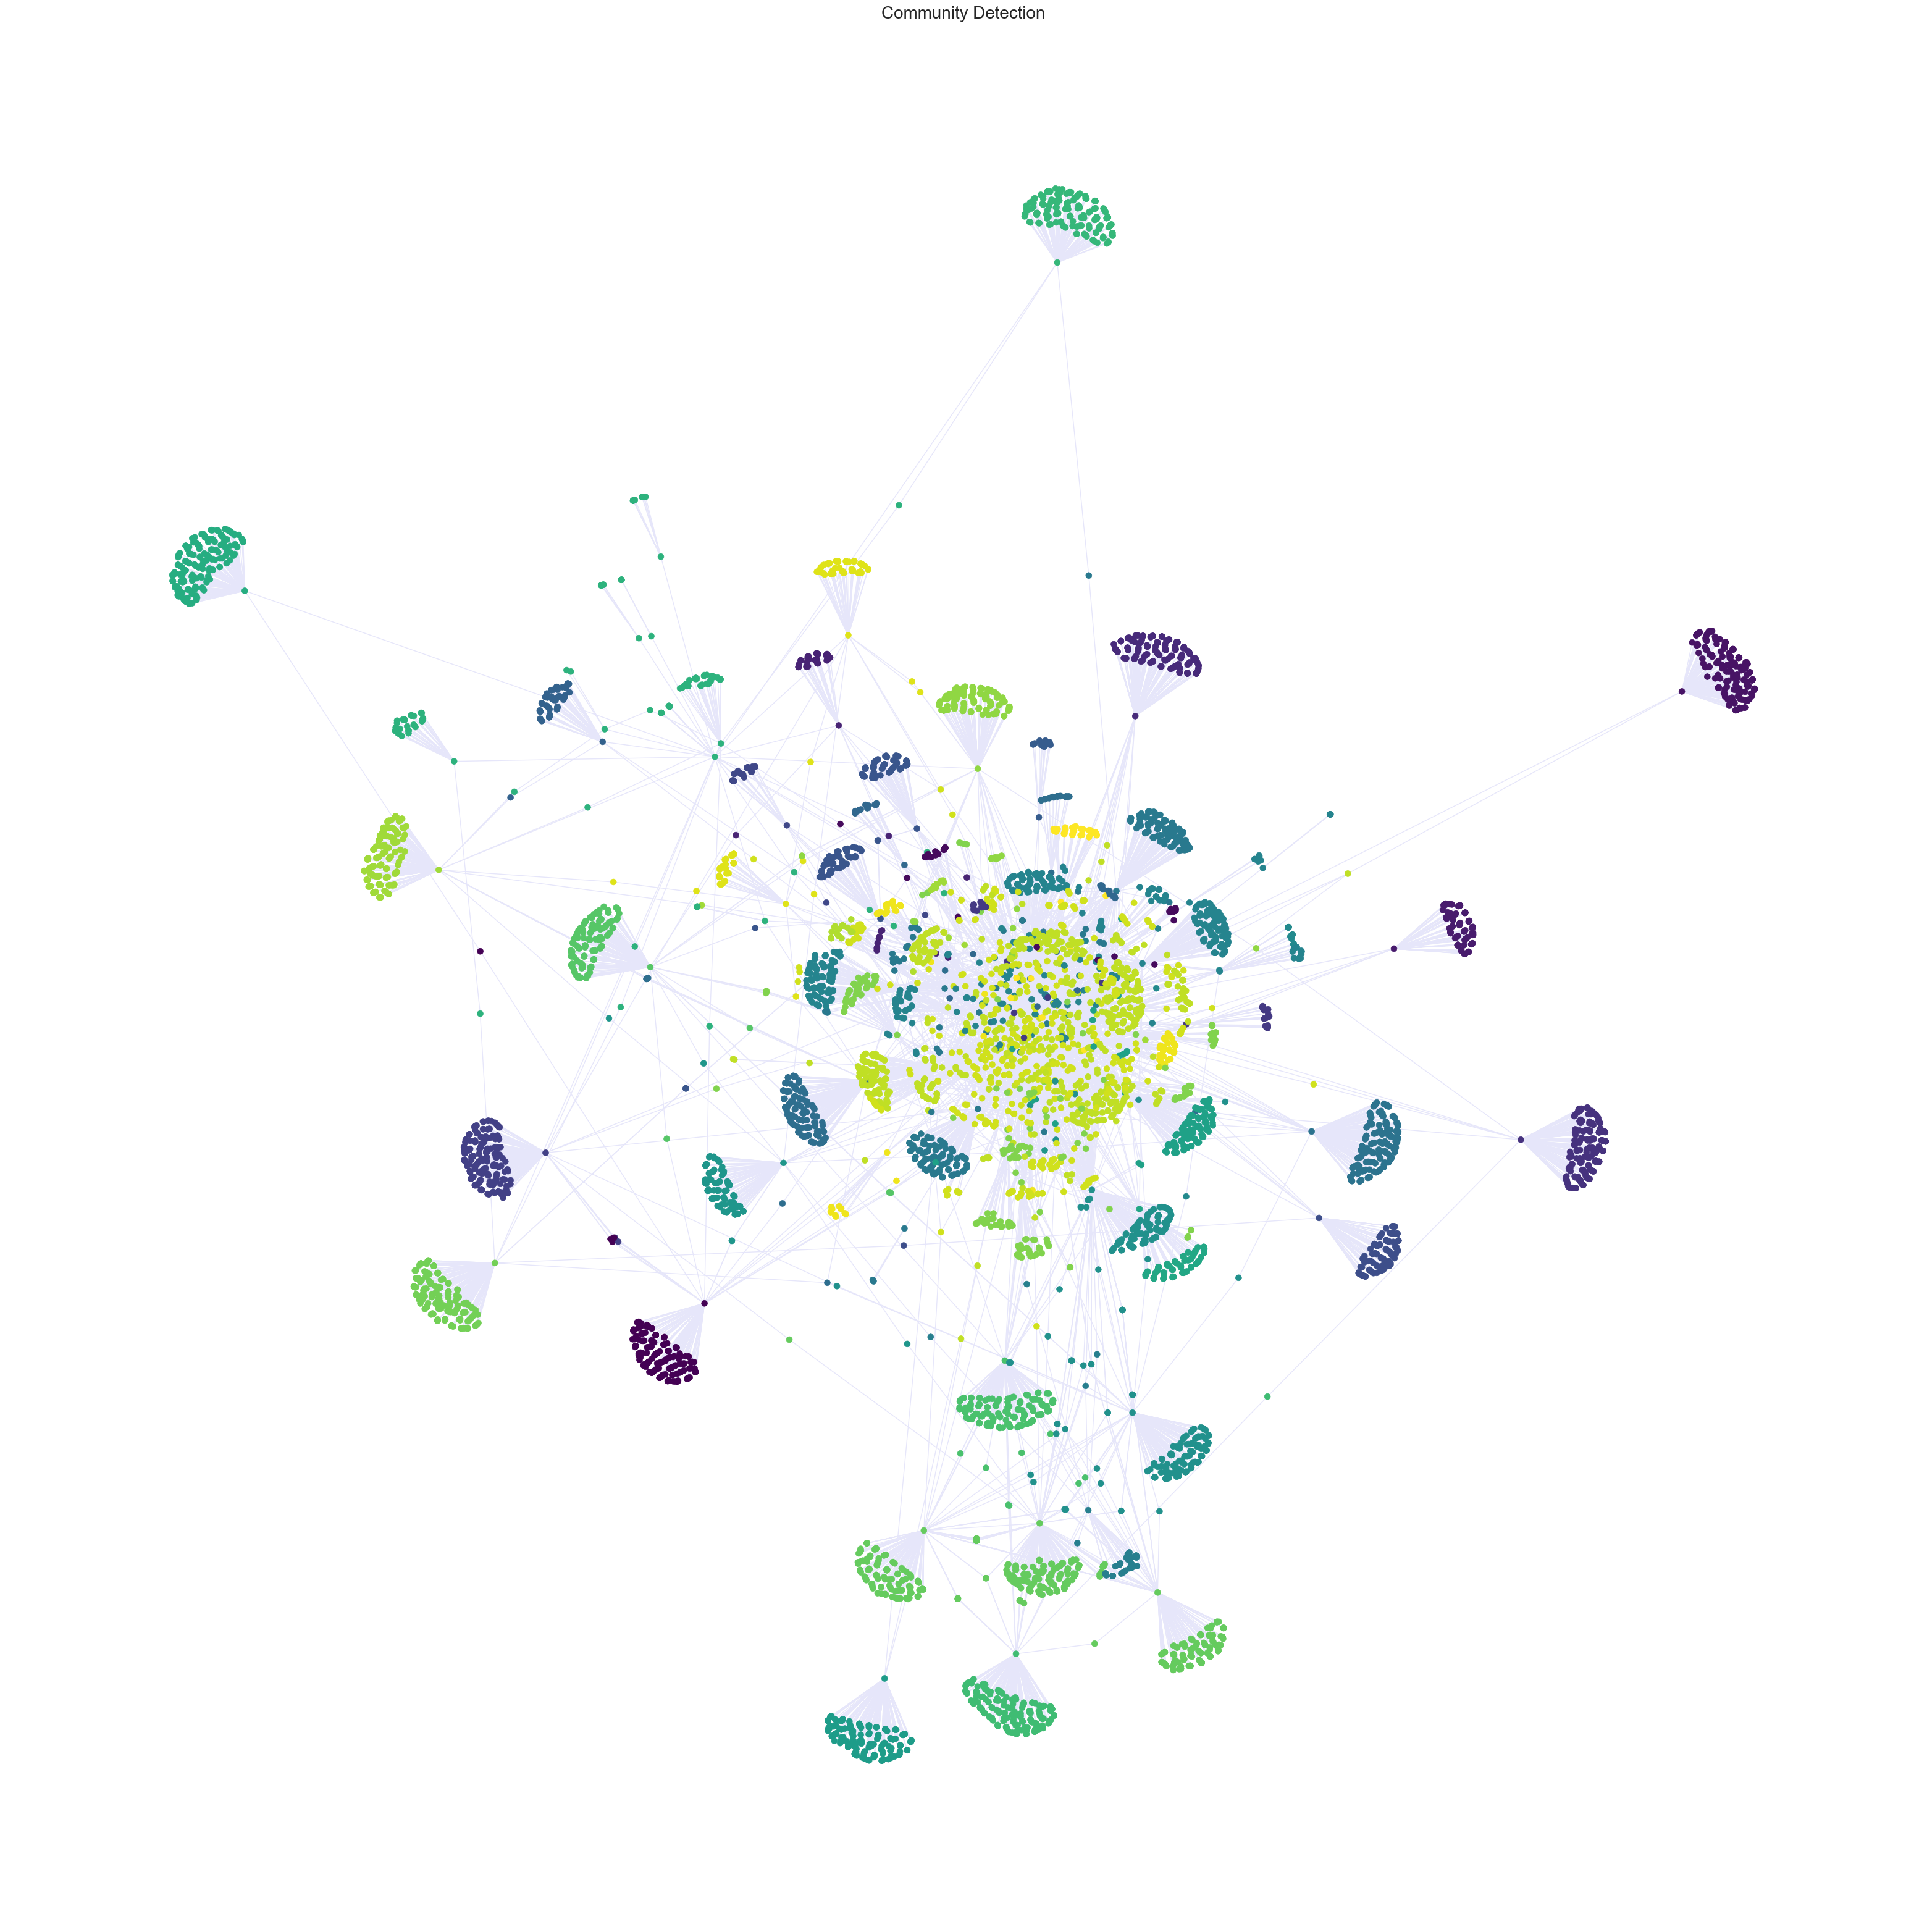

In [442]:
plt.figure(figsize=(40,40))
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx(G,
                 position,
                 cmap=cmap,
                 node_color=values, 
                 edge_color='lavender',
                 node_size=50, 
                 with_labels=False)
plt.title('Community Detection', size=20)
plt.axis('off')
plt.show()

In [479]:
commu_df=pd.DataFrame(partition.items(), columns=['account_id','commu'])

In [480]:
# commu = {}
# for i in values:
#     count = 0
#     if i not in commu:
#         commu[i] = count+1
#     else:
#         commu[i] = commu[i]+1

In [471]:
# commu_df=pd.DataFrame(sorted(commu.items(), key=lambda x:x[1], reverse=True)[:10], columns=['commu','members'])

In [494]:
commu_df.groupby('commu').count().reset_index().sort_values('account_id', ascending=False)[:10]

commu  account_id
38     38         776
19     19         512
32     32         505
39     39         454
17     17         333
21     21         310
34     34         218
36     36         201
2       2         200
28     28         199

In [ ]:
# project >> 38
# recipocity, degree, transitivity, local-coefficient
# - ลักษณะเฉพาะ, พฤติกรรม

## Post Analysis 

In [499]:
# betweeness centrality and on real accounts investigation 

In [ ]:
# เอากราฟ อร มาแปะ 

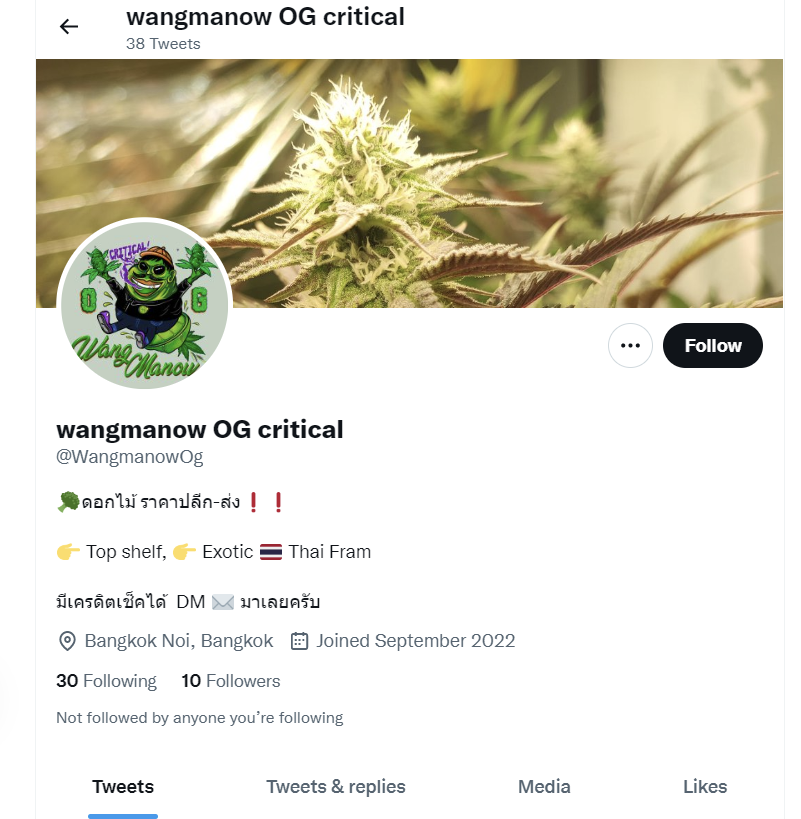

- มีผู้ติดตาม 30 บัญชี เป็นบัญชีที่มีการติดตามกลุ่มผู้ที่ขายกัญชารายที่มีการถูก Follower ที่สูงมากคือ BooK_Ku, nkx8yf4PxV8RccU, Mr.greenyard4420 และ SMOKINGOODSHOP เป็นต้น

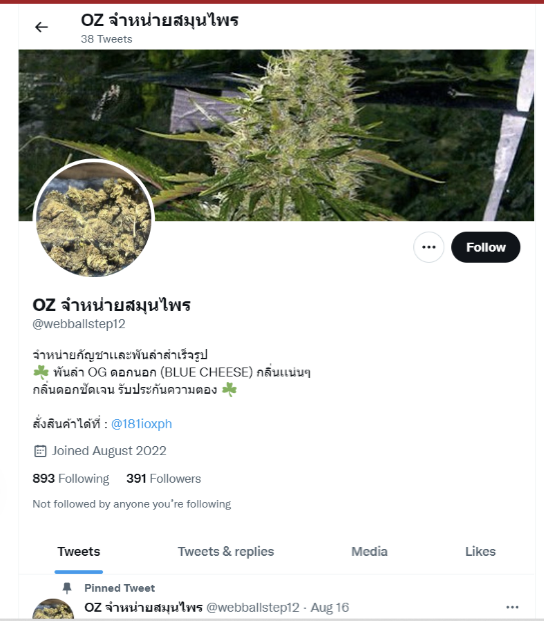

- มีผู้ติดตาม 391 บัญชี โดยมีผู้ติดตามที่เป็นผู้ขายกัญชารายอื่นจำนวนสูงมาก ๆ และมีทั้งผู้ที่สนใจจำนวนมากคอยติดตามน่าจะเป็นกลุ่มผู้ค้ารายใหญ่ที่มีความสัมพันธ์กันในเรื่องการขายส่ง


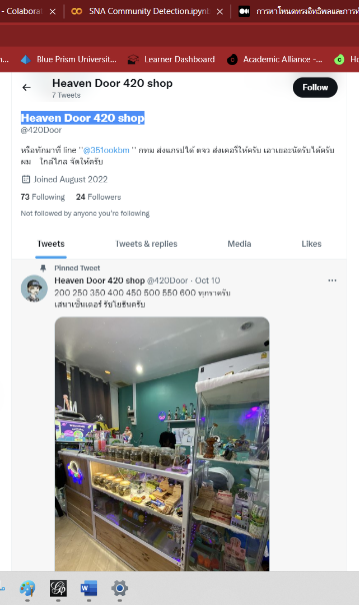

- @420Door  คือ ผู้ขายกัญชาที่มีหน้าร้านขายส่งเป็นทางการที่เสนาเซ็นเตอร์ รัชโยธิน มีการติดตามจากผู้ขายรายใหญ่ nkx8yf4PxV8RccU, ผู้ขายรายเล็ก  OGGANJA2, 42xWeeD